In [ ]:
!wget https://github.com/ongchinkiat/LyftPerceptionChallenge/releases/download/v0.1/carla-capture-20180513A.zip
!wget https://github.com/ongchinkiat/LyftPerceptionChallenge/releases/download/v0.1/carla-capture-20180528.zip
!wget https://github.com/ongchinkiat/LyftPerceptionChallenge/releases/download/v0.1/carla-capture-20181305.zip

In [ ]:
!mkdir -p data/train
!mkdir -p data/test

!unzip carla-capture-20180513A.zip
!mkdir -p CameraRGB/0
!mkdir -p CameraSeg/0
!mv CameraRGB/*.png CameraRGB/0
!mv CameraSeg/*.png CameraSeg/0
!mv CameraRGB data/train
!mv CameraSeg data/train

!unzip carla-capture-20180513A.zip
!mv CameraRGB/* data/train/CameraRGB/0
!mv CameraSeg/* data/train/CameraSeg/0

!unzip carla-capture-20181305.zip
!mkdir -p CameraRGB/0
!mkdir -p CameraSeg/0
!mv CameraRGB/*.png CameraRGB/0
!mv CameraSeg/*.png CameraSeg/0
!mv CameraRGB data/test
!mv CameraSeg data/test

In [1]:
import torch
import os
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import (
    ToTensor,
    Compose,
    Resize,
    PILToTensor,
    InterpolationMode,
    Lambda,    
)
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class ImageAndMaskDataset(Dataset):
    def __init__(self, d1, d2):
        super().__init__()
        self.d1 = d1
        self.d2 = d2

    def __len__(self):
        return len(self.d1)

    def __getitem__(self, i):
        return (self.d1[i][0], self.d2[i][0])


In [13]:
train_data = ImageAndMaskDataset(datasets.ImageFolder(
    root="data/train/CameraRGB",
    transform=Compose([Resize((96, 128)), ToTensor()]),
), datasets.ImageFolder(
    root="data/train/CameraSeg",
    transform=Compose(
        [
            Resize((96, 128), interpolation=InterpolationMode.NEAREST),
            PILToTensor(),
            Lambda(lambda x: torch.max(x, dim=0, keepdim=False)[0].type(torch.int64)),
        ]
    ),
))

test_data = ImageAndMaskDataset(datasets.ImageFolder(
    root="data/test/CameraRGB",
    transform=Compose([Resize((96, 128)), ToTensor()]),
), datasets.ImageFolder(
    root="data/test/CameraSeg",
    transform=Compose(
        [
            Resize((96, 128), interpolation=InterpolationMode.NEAREST),
            PILToTensor(),
            Lambda(lambda x: torch.max(x, dim=0, keepdim=False)[0].type(torch.int64)),
        ]
    ),
))


In [14]:
def display(image, mask, predict=None):
    _, arr = plt.subplots(1, 3 if predict != None else 2, figsize=(14, 10))

    arr[0].imshow(image.permute(1, 2, 0))
    arr[0].set_title("Image")
    arr[1].imshow(mask)
    arr[1].set_title("Mask")
    
    if predict != None:
        arr[2].imshow(predict)
        arr[2].set_title("Predicted mask")
    
    plt.show()

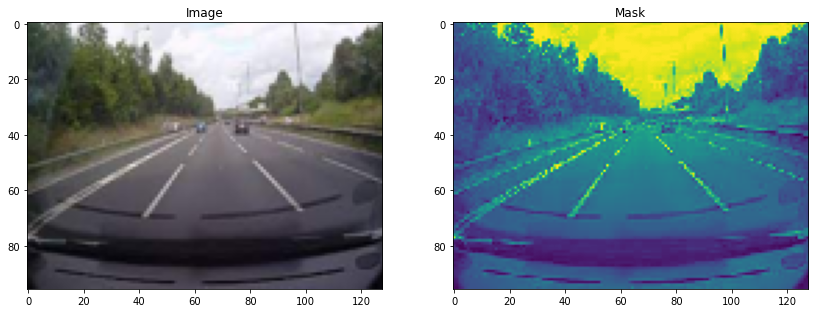

In [15]:
import random
N = random.randrange(len(test_data))
image, mask = test_data[N]
display(image, mask)

In [4]:
class DownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0, max_pooling=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout_prob = dropout_prob
        self.max_pooling = max_pooling

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        if dropout_prob > 0:
            self.conv.append(nn.Dropout(dropout_prob))

        if max_pooling:
            self.pool = nn.MaxPool2d(kernel_size=(2, 2))

    def forward(self, x):
        x = self.conv(x)
        if hasattr(self, "pool"):
            return (self.pool(x), x)
        return (x, x)


In [5]:
class UpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=(2, 2),
            stride=(2, 2),
            # output_padding=1,
        )

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding="same"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x, skip = x
        x = self.up(x)

        x = torch.concat([x, skip], dim=1)
        x = self.conv(x)
        return x


In [6]:
class UNet(nn.Module):
    def __init__(self, n_filters_base=32, n_classes=23):
        super(UNet, self).__init__()
        self.n_filters_base = n_filters_base
        self.n_classes = n_classes
        k = n_filters_base

        self.b1 = DownsamplingBlock(3, k)
        self.b2 = DownsamplingBlock(k, 2 * k)
        self.b3 = DownsamplingBlock(2 * k, 4 * k)
        self.b4 = DownsamplingBlock(4 * k, 8 * k, dropout_prob=0.3)

        self.mi = DownsamplingBlock(8 * k, 16 * k, dropout_prob=0.3, max_pooling=False)

        self.u4 = UpsamplingBlock(16 * k, 8 * k)
        self.u3 = UpsamplingBlock(8 * k, 4 * k)
        self.u2 = UpsamplingBlock(4 * k, 2 * k)
        self.u1 = UpsamplingBlock(2 * k, k)

        self.conv = nn.Sequential(
            nn.Conv2d(k, k, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.Conv2d(k, self.n_classes, kernel_size=(1, 1), padding="same"),
        )

    def forward(self, x):
        # Go down
        x, s1 = self.b1(x)
        x, s2 = self.b2(x)
        x, s3 = self.b3(x)
        x, s4 = self.b4(x)

        x, _ = self.mi(x)

        # Go up
        x = self.u4((x, s4))
        x = self.u3((x, s3))
        x = self.u2((x, s2))
        x = self.u1((x, s1))

        return self.conv(x)


In [18]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

for image, mask in train_dataloader:
    print("Shape of image [N, C, H, W]: ", image.shape, image.dtype)
    print("Shape of mask [N, 1, H, W]: ", mask.shape, mask.dtype)
    break

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Shape of image [N, C, H, W]:  torch.Size([32, 3, 96, 128]) torch.float32
Shape of mask [N, 1, H, W]:  torch.Size([32, 96, 128]) torch.int64
Using cpu device


In [19]:
model = UNet()
if os.path.exists("model_state.pth"):
    train = False
    model.load_state_dict(torch.load("model_state.pth", map_location=device))
else:
    train = True

model = model.to(device)
print(model)


UNet(
  (b1): DownsamplingBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (b2): DownsamplingBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

In [25]:
loss_fn = nn.CrossEntropyLoss()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    shape = dataloader.dataset[0][0].shape
    area = (shape[-1] * shape[-2])
    correct /= area
    print(f"Test Error:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

if train:    
    optimizer = torch.optim.Adam(model.parameters())

    def train(dataloader, model, loss_fn, optimizer):
        size = len(dataloader.dataset)
        model.train()
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, Y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 5 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    epochs = 40
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)

    print("Done!")
    if input('Do u wanna save the model [y/N]: ').lower().startswith("y"):
        torch.save(model.state_dict(), "model_state.pth")

else:
    test(test_dataloader, model, loss_fn)


Test Error:
Accuracy: 89.2%, Avg loss: 0.472410 



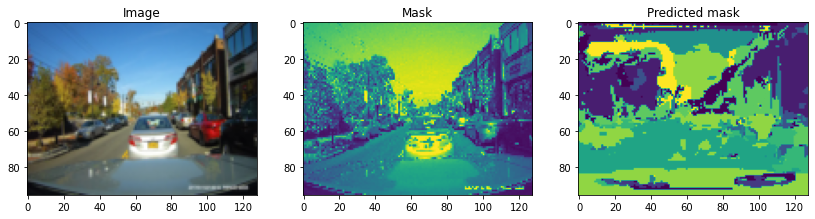

In [22]:
import random
N = random.randrange(batch_size)
model.eval()

with torch.no_grad():
    for (X, Y) in test_dataloader:
        X, Y = X.to(device), Y.to(device)

        # Predict
        y = model(X)
        mask = y[0, :, :, :].cpu().argmax(dim=0)
        X = X[0, :, :, :].cpu()
        Y = Y[0, :, :].cpu()

        display(X, Y, mask)
        break